# Mono-Agent Reinforcement Learning: A Gentle, Chronological Walkthrough

This notebook teaches the basics of *single-agent* reinforcement learning (RL) in **chronological order**, from early ideas like bandits to modern deep RL. It is written as if you are learning line by line, step by step.

**Goal:** start with almost no assumptions, build the math and intuition gradually, and then implement each algorithm using standard academic tools (NumPy, PyTorch, Gymnasium, Pandas).


## How to use this notebook

1. Read the markdown carefully.
2. Run every cell in order.
3. Pause to interpret each result before moving on.
4. If something is unclear, scroll up and re-read the comments.

This is intentionally slow and explanatory. It is fine if it feels long!

## Learning objectives

By the end, you will be able to:
- Define the core RL terms (agent, environment, state, action, reward, episode).
- Implement epsilon-greedy bandits.
- Solve tabular MDPs with value iteration.
- Learn with SARSA and Q-learning.
- Use function approximation with Deep Q-Networks (DQN).
- Train a policy with REINFORCE (policy gradients).
- Record a trained agent interacting with the environment.


In [1]:
# Core scientific tools
import math  # For small mathematical utilities
import random  # For Python-level randomness
from dataclasses import dataclass  # For clean small data containers

import numpy as np  # Fast arrays and numerical operations
import pandas as pd  # Friendly tables for results
import matplotlib.pyplot as plt  # Simple plotting

# Deep learning (for modern RL)
import torch  # Tensors and autograd
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimizers

# RL environments
import gymnasium as gym  # Standard RL environments

# Jupyter helpers for video
from IPython.display import Video  # Display recorded videos

# Make plots look a bit nicer
plt.style.use('seaborn-v0_8')

# Global seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


## 0. The RL story in one paragraph

Reinforcement learning is about **learning by trial and error**. An **agent** takes an **action** in an **environment**, receives a **reward**, and observes a new **state**. The goal is to choose actions that maximize total future reward.

Historically, RL started with simple problems (bandits), then moved to full Markov Decision Processes (MDPs), and later to learning *value functions* and *policies* with neural networks. We'll follow that historical path.


## 1. Multi-armed bandits (the earliest RL model)

Imagine a casino row of slot machines ("arms"), each with its own unknown payout.
You want to learn which arm is best *while still exploring*.

This is the **exploration vs. exploitation** dilemma, one of the oldest ideas in RL.

We will implement a simple **epsilon-greedy** bandit: most of the time we choose the best known arm, but sometimes we explore.


In [2]:
# A tiny class to simulate a K-armed bandit
class GaussianBandit:
    def __init__(self, k=5, seed=SEED):
        # Each arm has a hidden mean reward
        rng = np.random.default_rng(seed)
        self.means = rng.normal(loc=0.0, scale=1.0, size=k)
        self.k = k

    def pull(self, arm):
        # Reward is noisy around the true mean
        return np.random.normal(self.means[arm], 1.0)

    def optimal_arm(self):
        # Index of the best arm (unknown to the agent)
        return int(np.argmax(self.means))

# Epsilon-greedy training loop
def train_epsilon_greedy(bandit, steps=2000, epsilon=0.1):
    # Q-values are our current guesses of each arm's average reward
    q_values = np.zeros(bandit.k, dtype=np.float64)
    # Counts track how many times we tried each arm
    counts = np.zeros(bandit.k, dtype=np.int64)

    rewards = []  # Store reward history to plot later
    chosen_arms = []  # Track which arm we chose

    for t in range(steps):
        # With probability epsilon, explore a random arm
        if np.random.rand() < epsilon:
            arm = np.random.randint(bandit.k)
        else:
            # Otherwise exploit the best known arm
            arm = int(np.argmax(q_values))

        # Pull the chosen arm and observe reward
        reward = bandit.pull(arm)

        # Update counts and running average (incremental mean)
        counts[arm] += 1
        q_values[arm] += (reward - q_values[arm]) / counts[arm]

        # Log for analysis
        rewards.append(reward)
        chosen_arms.append(arm)

    return {
        'q_values': q_values,
        'counts': counts,
        'rewards': np.array(rewards),
        'chosen_arms': np.array(chosen_arms),
    }

# Run the bandit experiment
bandit = GaussianBandit(k=5, seed=SEED)
results = train_epsilon_greedy(bandit, steps=2000, epsilon=0.1)

# Summarize results in a friendly table
summary = pd.DataFrame({
    'arm': np.arange(bandit.k),
    'true_mean': bandit.means,
    'estimated_mean': results['q_values'],
    'times_chosen': results['counts'],
})
summary


,arm,true_mean,estimated_mean,times_chosen
0,0,0.304717,0.208617,57
1,1,-1.039984,-1.018267,39
2,2,0.750451,0.692672,57
3,3,0.940565,0.942244,1807
4,4,-1.951035,-2.205135,40


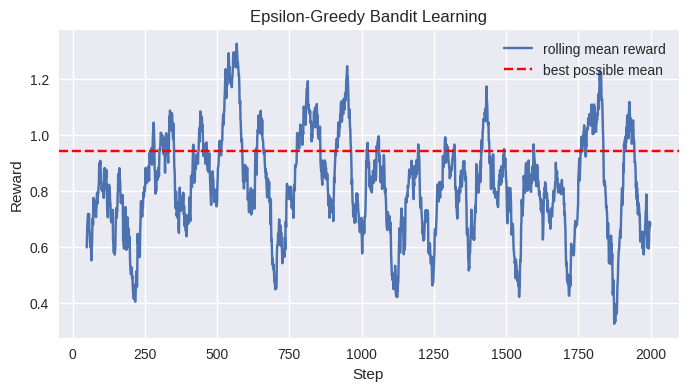

In [4]:
# Plot the reward over time to see learning
plt.figure(figsize=(8, 4))
plt.plot(pd.Series(results['rewards']).rolling(50).mean(), label='rolling mean reward')
plt.axhline(bandit.means[bandit.optimal_arm()], color='red', linestyle='--', label='best possible mean')
plt.title('Epsilon-Greedy Bandit Learning')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()


### Historical note

The bandit problem is older than RL itself. It was studied in statistics and decision theory
long before computers could simulate complex environments. Many modern RL ideas were first
tested in bandits because they are the simplest possible decision problem.


## 2. Markov Decision Processes (MDPs)

Bandits have no states. In real RL, actions change the world and create new situations.

An MDP is defined by:
- **States** (S)
- **Actions** (A)
- **Transition probabilities** P(s' | s, a)
- **Rewards** R(s, a, s')
- **Discount factor** gamma (how much we care about the future)

We will use a tiny environment from Gymnasium to make this concrete.


In [5]:
# Create a simple discrete environment
env = gym.make('FrozenLake-v1', is_slippery=False)  # deterministic for clarity

# Inspect state and action spaces
print('Number of states:', env.observation_space.n)
print('Number of actions:', env.action_space.n)

# Reset environment to get initial state
state, info = env.reset(seed=SEED)
print('Initial state:', state)

# Take one random action to see the step output
action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
print('Action:', action)
print('Next state:', next_state)
print('Reward:', reward)
print('Done:', terminated or truncated)


Number of states: 16
Number of actions: 4
Initial state: 0
Action: 1
Next state: 4
Reward: 0
Done: False


## 3. Dynamic programming: Value Iteration (1950s-1960s)

Early RL researchers assumed they **knew** the full MDP model.
With full knowledge, you can compute optimal values exactly using dynamic programming.

We will implement **value iteration**, which repeatedly applies the Bellman optimality update:

$V(s) = max_a sum_{s'} P(s'|s,a) [R(s,a,s') + gamma * V(s')]$

Then we extract a greedy policy.


In [6]:
def value_iteration(env, gamma=0.99, theta=1e-6):
    # We use the unwrapped environment to access transition probabilities
    P = env.unwrapped.P
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Start with zero values for all states
    V = np.zeros(n_states, dtype=np.float64)

    while True:
        delta = 0.0
        # Update each state's value
        for s in range(n_states):
            v_old = V[s]
            # Compute the value of each action
            action_values = []
            for a in range(n_actions):
                q_sa = 0.0
                for prob, next_s, reward, done in P[s][a]:
                    # If done, the next value is 0 by definition (episode ends)
                    next_v = 0.0 if done else V[next_s]
                    q_sa += prob * (reward + gamma * next_v)
                action_values.append(q_sa)
            # Bellman optimality update
            V[s] = max(action_values)
            delta = max(delta, abs(v_old - V[s]))
        # Stop when updates are very small
        if delta < theta:
            break

    # Extract a greedy policy from V
    policy = np.zeros(n_states, dtype=np.int64)
    for s in range(n_states):
        action_values = []
        for a in range(n_actions):
            q_sa = 0.0
            for prob, next_s, reward, done in P[s][a]:
                next_v = 0.0 if done else V[next_s]
                q_sa += prob * (reward + gamma * next_v)
            action_values.append(q_sa)
        policy[s] = int(np.argmax(action_values))

    return V, policy

V_opt, pi_opt = value_iteration(env, gamma=0.99)
print('Optimal value for state 0:', V_opt[0])
print('Greedy action at state 0:', pi_opt[0])


Optimal value for state 0: 0.9509900498999999
Greedy action at state 0: 1


In [7]:
# Evaluate the greedy policy by simulation
def evaluate_policy(env, policy, episodes=200):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0
        while not done:
            action = policy[state]
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

avg_return = evaluate_policy(env, pi_opt, episodes=200)
print('Average return of optimal policy:', avg_return)


Average return of optimal policy: 1.0


## 4. Temporal-Difference (TD) Learning: SARSA and Q-learning (1980s-1990s)

Dynamic programming assumes we know the full model. In real life, we often **do not**.
TD methods learn directly from experience by bootstrapping.

- **SARSA** is on-policy: it learns the value of the policy it is actually following.
- **Q-learning** is off-policy: it learns the best possible values even if it explores.

We will implement both in a tabular setting (FrozenLake).


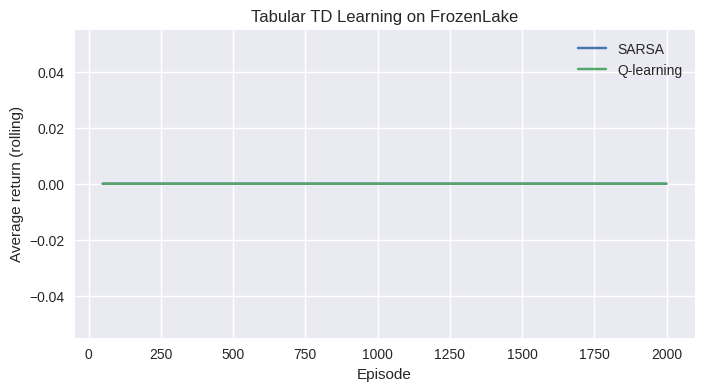

In [8]:
def epsilon_greedy(q_table, state, epsilon):
    # Random action with probability epsilon, otherwise best known action
    if np.random.rand() < epsilon:
        return np.random.randint(q_table.shape[1])
    return int(np.argmax(q_table[state]))

def train_sarsa(env, episodes=2000, alpha=0.1, gamma=0.99, epsilon=0.1):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions), dtype=np.float64)
    returns = []

    for _ in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(q, state, epsilon)
        done = False
        episode_return = 0.0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(q, next_state, epsilon)

            # SARSA update (on-policy)
            td_target = reward + gamma * q[next_state, next_action] * (0.0 if done else 1.0)
            td_error = td_target - q[state, action]
            q[state, action] += alpha * td_error

            state, action = next_state, next_action
            episode_return += reward

        returns.append(episode_return)

    return q, np.array(returns)

def train_q_learning(env, episodes=2000, alpha=0.1, gamma=0.99, epsilon=0.1):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions), dtype=np.float64)
    returns = []

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_return = 0.0

        while not done:
            action = epsilon_greedy(q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-learning update (off-policy)
            best_next = np.max(q[next_state])
            td_target = reward + gamma * best_next * (0.0 if done else 1.0)
            td_error = td_target - q[state, action]
            q[state, action] += alpha * td_error

            state = next_state
            episode_return += reward

        returns.append(episode_return)

    return q, np.array(returns)

q_sarsa, returns_sarsa = train_sarsa(env, episodes=2000, alpha=0.1, epsilon=0.1)
q_qlearn, returns_qlearn = train_q_learning(env, episodes=2000, alpha=0.1, epsilon=0.1)

# Compare learning curves
plt.figure(figsize=(8, 4))
plt.plot(pd.Series(returns_sarsa).rolling(50).mean(), label='SARSA')
plt.plot(pd.Series(returns_qlearn).rolling(50).mean(), label='Q-learning')
plt.title('Tabular TD Learning on FrozenLake')
plt.xlabel('Episode')
plt.ylabel('Average return (rolling)')
plt.legend()
plt.show()


## 5. Function approximation: Deep Q-Networks (2013-2015)

Tabular Q-learning breaks when states are large or continuous.
Deep Q-Networks (DQN) use a neural network to approximate Q(s, a).

Key ideas:
- Replay buffer (learn from past transitions)
- Target network (stabilize learning)
- Neural network function approximation

We will train a DQN on CartPole, a classic control problem.


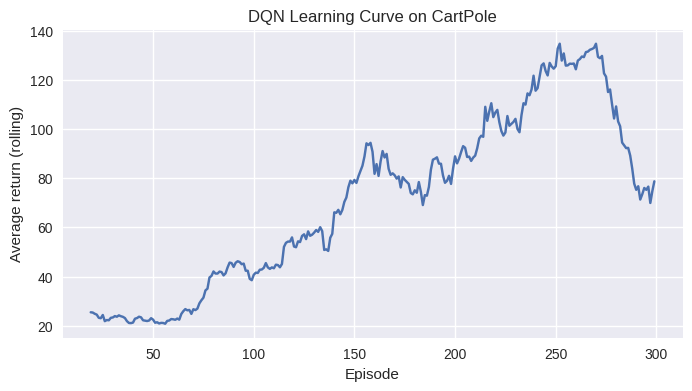

In [9]:
# Simple replay buffer to store transitions
@dataclass
class Transition:
    state: np.ndarray
    action: int
    reward: float
    next_state: np.ndarray
    done: bool

class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, transition):
        # Insert or overwrite oldest transition
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        # Random sample for training
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in idxs]
        return batch

    def __len__(self):
        return len(self.buffer)

# Q-network for CartPole (small MLP)
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )

    def forward(self, x):
        return self.net(x)

def train_dqn(env_id='CartPole-v1', episodes=300, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
              batch_size=64, lr=1e-3, target_update=20):
    env = gym.make(env_id)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=50000)

    epsilon = epsilon_start
    returns = []

    for ep in range(episodes):
        state, _ = env.reset(seed=SEED + ep)
        done = False
        episode_return = 0.0

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = int(torch.argmax(q_values, dim=1).item())

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition in replay buffer
            buffer.push(Transition(state, action, reward, next_state, done))
            state = next_state
            episode_return += reward

            # Start training only when buffer has enough samples
            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                states = torch.tensor(np.array([t.state for t in batch]), dtype=torch.float32)
                actions = torch.tensor([t.action for t in batch], dtype=torch.int64).unsqueeze(1)
                rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32).unsqueeze(1)
                next_states = torch.tensor(np.array([t.next_state for t in batch]), dtype=torch.float32)
                dones = torch.tensor([t.done for t in batch], dtype=torch.float32).unsqueeze(1)

                # Current Q estimates
                q_current = policy_net(states).gather(1, actions)

                # Target Q values from target network
                with torch.no_grad():
                    q_next = target_net(next_states).max(1, keepdim=True)[0]
                    q_target = rewards + gamma * q_next * (1.0 - dones)

                # Mean squared error loss
                loss = nn.MSELoss()(q_current, q_target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon after each episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        returns.append(episode_return)

        # Periodically update target network
        if (ep + 1) % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    env.close()
    return policy_net, returns

dqn_policy, dqn_returns = train_dqn(episodes=300)

plt.figure(figsize=(8, 4))
plt.plot(pd.Series(dqn_returns).rolling(20).mean())
plt.title('DQN Learning Curve on CartPole')
plt.xlabel('Episode')
plt.ylabel('Average return (rolling)')
plt.show()


## 6. Policy Gradients: REINFORCE (1992)

Value-based methods (like Q-learning) choose actions by maximizing estimated values.
Policy gradient methods **directly** optimize the policy itself.

REINFORCE is the simplest policy gradient algorithm. The idea is:
- Run an episode
- Compute the return (future reward) for each step
- Push the policy to increase the probability of actions that led to high returns

This is historically important because it opened the door to modern actor-critic methods.


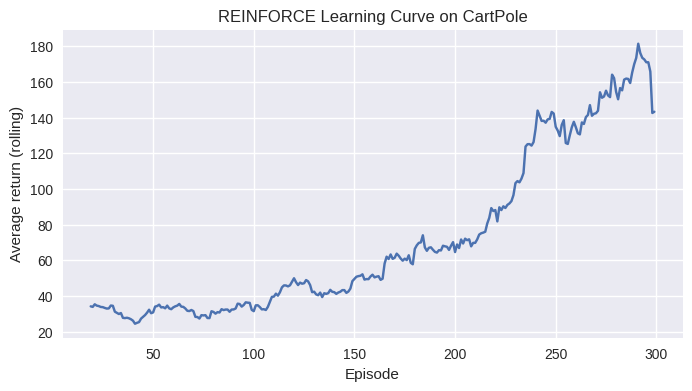

In [10]:
# Simple policy network for CartPole
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        # Output raw logits (we will apply softmax later)
        return self.net(x)

def train_reinforce(env_id='CartPole-v1', episodes=300, gamma=0.99, lr=1e-3):
    env = gym.make(env_id)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy = PolicyNetwork(state_dim, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    returns_history = []

    for ep in range(episodes):
        state, _ = env.reset(seed=SEED + 1000 + ep)
        done = False

        # Store episode trajectory
        log_probs = []
        rewards = []

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            logits = policy(state_tensor)
            action_probs = torch.softmax(logits, dim=1)

            # Sample an action from the policy distribution
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            rewards.append(reward)
            state = next_state

        # Compute discounted returns G_t
        returns = []
        G = 0.0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32)

        # Normalize returns to reduce variance (classic trick)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Policy gradient loss: maximize log_prob * return
        loss = 0.0
        for log_prob, G_t in zip(log_probs, returns):
            loss += -log_prob * G_t

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        returns_history.append(sum(rewards))

    env.close()
    return policy, returns_history

reinforce_policy, reinforce_returns = train_reinforce(episodes=300)

plt.figure(figsize=(8, 4))
plt.plot(pd.Series(reinforce_returns).rolling(20).mean())
plt.title('REINFORCE Learning Curve on CartPole')
plt.xlabel('Episode')
plt.ylabel('Average return (rolling)')
plt.show()


## 7. Visualizing a trained agent

Now we will record a *trained* agent interacting with the environment.
This creates an `.mp4` file and displays it directly in the notebook.

We will use the DQN policy because it is deterministic and easy to visualize.


In [12]:
import os  # For filesystem paths
import glob  # For finding the recorded video file

def record_dqn_policy_video(policy_net, env_id='CartPole-v1', video_dir='videos'):
    # Make sure the output directory exists
    os.makedirs(video_dir, exist_ok=True)

    # Create environment with video recording wrapper
    env = gym.make(env_id, render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda ep: True)

    state, _ = env.reset(seed=SEED + 999)
    done = False
    while not done:
        # Choose best action from the trained Q-network
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(state_tensor)
            action = int(torch.argmax(q_values, dim=1).item())

        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state

    env.close()

    # Find the most recent video file
    video_files = glob.glob(os.path.join(video_dir, '*.mp4'))
    if not video_files:
        raise FileNotFoundError('No video files were found.')
    latest_video = max(video_files, key=os.path.getmtime)
    return latest_video

video_path = record_dqn_policy_video(dqn_policy)
Video(video_path, embed=True)


## 8. Where to go next

You have now seen the main historical progression of mono-agent RL.
Future notebooks will expand on these ideas with:
- Actor-Critic methods (A2C, A3C)
- More stable deep RL (Double DQN, Dueling DQN)
- Modern policy optimization (PPO, SAC)
- Multi-agent extensions

If you want to explore hyperparameter tuning, you can later integrate tools like Optuna
to automate the search over learning rates, epsilon schedules, and network sizes.
